In [1]:
import os
os.chdir('../../')
os.getcwd()

'/Users/henriquecosta/workspace/studies/modern-ml'

In [24]:
import pandas as pd
import numpy as np
import catboost as cb
from sklearn.metrics import log_loss, average_precision_score
from sklearn.model_selection import train_test_split
from venn_abers import VennAbersCalibrator
from matplotlib import pyplot as plt
import seaborn as sns
import mlflow

In [3]:
mlflow.set_experiment('final_model')

2025/02/02 20:14:56 INFO mlflow.tracking.fluent: Experiment with name 'final_model' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/henriquecosta/workspace/studies/modern-ml/mlruns/614710356249417379', creation_time=1738538096390, experiment_id='614710356249417379', last_update_time=1738538096390, lifecycle_stage='active', name='final_model', tags={}>

In [4]:
df_train = pd.read_parquet('./case/data/processed/lending_club_case_train_dataset_v2.parquet')
df_valid = pd.read_parquet('./case/data/processed/lending_club_case_valid_dataset_v2.parquet')
df_test  = pd.read_parquet('./case/data/processed/lending_club_case_test_dataset_v2.parquet')

In [5]:
FEATURES = [
    'loan_amnt',
    'term',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'fico_range_low',
    'inq_last_6mths',
    'mths_since_last_delinq',
    'revol_bal',
    'total_rev_hi_lim',
    'acc_open_past_24mths',
    'bc_open_to_buy',
    'bc_util',
    'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl',
    'mort_acc',
    'mths_since_recent_bc',
    'mths_since_recent_inq',
    'num_bc_tl',
    'num_il_tl',
    'num_rev_tl_bal_gt_0',
    'percent_bc_gt_75',
    'tot_hi_cred_lim',
    'total_bc_limit',
    'total_il_high_credit_limit',
    'issue_d_elapse',
    'earliest_cr_line_since',
    'grade',
    'sub_grade',
    'emp_length',
    'home_ownership',
    'verification_status',
    'pymnt_plan',
    'purpose',
    'title',
    'zip_code',
    'addr_state',
    'initial_list_status',
    'application_type',
    'verification_status_joint',
    'issue_d_month',
    'issue_d_day',
    'issue_d_dayofweek',
    'issue_d_dayofyear',
    'issue_d_quarter',
    'earliest_cr_line_month',
    'earliest_cr_line_day',
    'earliest_cr_line_dayofweek',
    'earliest_cr_line_dayofyear',
    'earliest_cr_line_quarter',
    'sec_app_earliest_cr_line_month',
    'sec_app_earliest_cr_line_day',
    'sec_app_earliest_cr_line_dayofweek',
    'sec_app_earliest_cr_line_dayofyear',
    'sec_app_earliest_cr_line_quarter'
]

CATEGORICAL_FEATURES = [c for c in df_train.select_dtypes(include='category').columns if c in FEATURES]

In [6]:
X_train = df_train[FEATURES]
y_train = df_train['default']

X_valid = df_valid[FEATURES]
y_valid = df_valid['default']

X_test = df_test[FEATURES]

In [7]:
X_valid, X_calibration, y_valid, y_calibration = train_test_split(X_valid, y_valid, test_size=.2, random_state=42)

In [8]:
train_pool  = cb.Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = cb.Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES)

In [9]:
with mlflow.start_run(run_name='calibrated_model'):
    params = dict(
        iterations=5000,
        colsample_bylevel=0.7,
        depth=8,
        l2_leaf_reg=2.0,
        learning_rate=0.09476737092755798,
        auto_class_weights='SqrtBalanced',
        eval_metric='Logloss',
        verbose=10,
    )

    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100)
    y_pred = model.predict_proba(X_valid)[:, 1]
    mlflow.log_params(params)
    mlflow.log_metric('log_loss_non_calibrated', log_loss(y_valid, y_pred))
    mlflow.log_metric('avg_pr_non_calibrated', average_precision_score(y_valid, y_pred))

    p_cal = model.predict_proba(X_calibration)
    p_val = model.predict_proba(X_valid)
    va = VennAbersCalibrator()
    va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_val)
    y_pred_va = va_prefit_prob[:, 1]
    mlflow.log_metric('log_loss', log_loss(y_valid, y_pred_va))
    mlflow.log_metric('avg_pr', average_precision_score(y_valid, y_pred_va))

python(60272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60274) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(60275) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


0:	learn: 0.6689975	test: 0.6743545	best: 0.6743545 (0)	total: 5.88s	remaining: 8h 9m 39s
10:	learn: 0.5801940	test: 0.6142167	best: 0.6142167 (10)	total: 31.7s	remaining: 3h 59m 51s
20:	learn: 0.5664953	test: 0.6103368	best: 0.6103368 (20)	total: 2m 15s	remaining: 8h 56m 25s
30:	learn: 0.5621825	test: 0.6094678	best: 0.6094678 (30)	total: 2m 52s	remaining: 7h 41m 42s
40:	learn: 0.5600689	test: 0.6084507	best: 0.6084507 (40)	total: 4m 48s	remaining: 9h 40m 39s
50:	learn: 0.5587043	test: 0.6074108	best: 0.6074108 (50)	total: 5m 55s	remaining: 9h 35m 16s
60:	learn: 0.5577833	test: 0.6064840	best: 0.6064840 (60)	total: 6m 21s	remaining: 8h 35m 1s
70:	learn: 0.5569825	test: 0.6062517	best: 0.6062467 (66)	total: 6m 43s	remaining: 7h 47m 7s
80:	learn: 0.5562837	test: 0.6057267	best: 0.6057267 (80)	total: 7m 5s	remaining: 7h 10m 31s
90:	learn: 0.5556178	test: 0.6045309	best: 0.6045309 (90)	total: 7m 29s	remaining: 6h 44m 4s
100:	learn: 0.5550448	test: 0.6038982	best: 0.6037995 (98)	total: 7m 

In [10]:
p_test = model.predict_proba(X_test)
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_test)
y_submit_va = va_prefit_prob[:, 1]

In [13]:
submission = df_test[['id']].copy()
submission['probabilities'] = y_submit_va

submission.to_csv('./case/data/submission/henrique_schumann.csv', index=False)

In [15]:
test_file = pd.read_parquet('./case/data/processed/test_dataset_with_target.parquet')[['id', 'default']]
test_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538826 entries, 472065 to 1082981
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       538826 non-null  Int64  
 1   default  208329 non-null  float16
dtypes: Int64(1), float16(1)
memory usage: 9.8 MB


In [16]:
test_file = test_file.merge(submission, on='id', how='inner')
test_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538826 entries, 0 to 538825
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             538826 non-null  Int64  
 1   default        208329 non-null  float16
 2   probabilities  538826 non-null  float64
dtypes: Int64(1), float16(1), float64(1)
memory usage: 9.8 MB


In [17]:
test_file = test_file.dropna()

y_true = test_file['default']
y_pred = test_file['probabilities']

print('Final Logloss:', log_loss(y_true, y_pred))

Final Logloss: 0.48720282735720877


In [22]:
test_file['default'] = test_file['default'].astype(int)

<Axes: xlabel='default'>

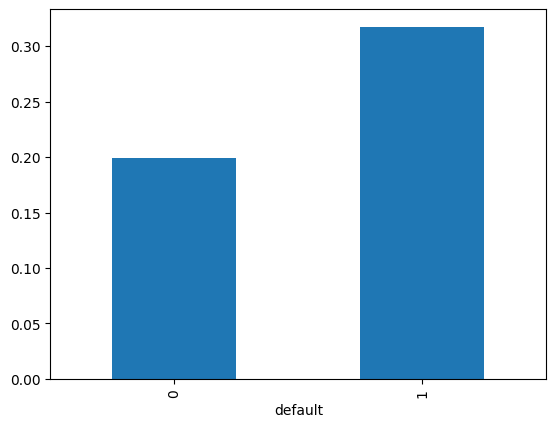

In [26]:
test_file.groupby('default')['probabilities'].mean().plot.bar()

In [29]:
test_file['default'].isnull().mean()

0.0

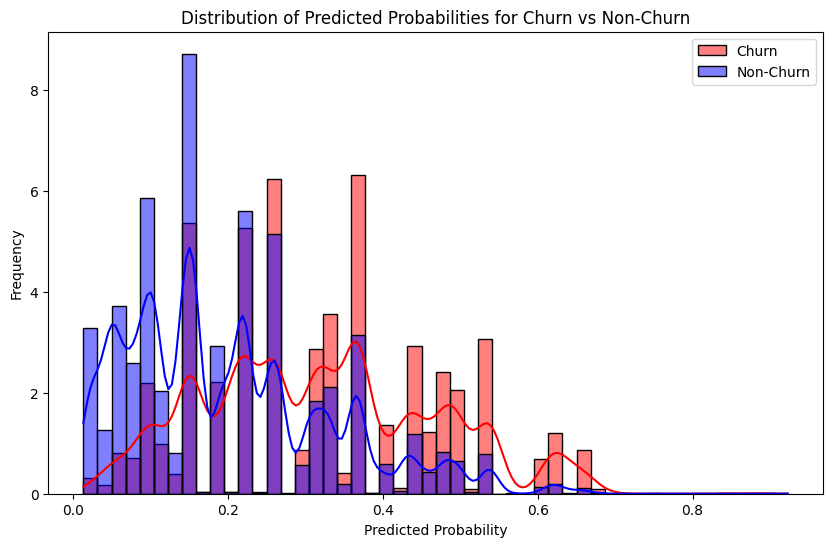

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(test_file.loc[test_file['default'] == 1, 'probabilities'], bins=50, color='red', label='Churn', kde=True, stat='density')
sns.histplot(test_file.loc[test_file['default'] == 0, 'probabilities'], bins=50, color='blue', label='Non-Churn', kde=True, stat='density')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities for Churn vs Non-Churn')
plt.legend()